<center>
<img style="float: left;" width="200" src="../img/one.png">
<div style="text-align: Center">Text Classification in Tensor Flow </div>
<div style="text-align: Center">Pawel Sobieralski, 2022 </div>
</center>

# Solution Design


## Description:
For text classification there are 3 possible solutions:
1. Traditional solution: embedding with TF-IDF and Naive Bayes classifier. Alternatively Logistic Regression or shalow Neural Network
2. <b>Tensor Flow solutution: embedding by converting text to sequences and applying TF deep learning clasifier</b>
3. BERT - Google's language model  
4. Aditionaly Gensim provides interesting API for embedding, topic modeling etc. that could be used in conjunction with the above.

This is Tensor Flow solution

## Example usage:

<strong>Read Input Data</strong>  
raw_data = se_make_sample_corpus()

<strong>Standardization</strong>  
raw_data['document'] = se_standardization(raw_data['document'])

<strong>Validation Split</strong>  
data = se_validation_split(raw_data, k)

<strong>Vectorize Data</strong>  
data_training_ready = se_vectorize(data,vocab_size )

<strong>Build Tensor Flow Model</strong>  
model = se_build_model(vocab_size, embedding_dim, max_length)

<strong>Train Model</strong>  
history = se_train_model(model, data_training_ready, num_epochs)

<strong>Validate Model</strong>  
se_se_validate_model(history)

## Files list
Text Classification in Tensor Flow Jupier Notebook  
text_classification_in_tf.py

In [17]:
import sys
sys.path.append("../Python")


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import re
import string

import utils # utils build for this project

print(tf.__version__)

2.8.0


# Read in Input Data

In [18]:
def make_sample_corpus():
    text_corpus = [
        "Human machine accusations for lab allegations applications",
        "A survey of user opinion of allegations charges response time",
        "The EPS user accusations management charges",
        "charges and human charges engineering testing of EPS",
        "Relation of user perceived response time to error measurement",
        "The generation of random binary unordered conviction",
        "The intersection sentencing of paths in conviction",
        "Sentencing minors IV Widths of conviction and well quasi ordering",
        "Sentencing minors A survey",
    ]
    labels = [0,0,0,0,0,1,1,1,1]

    return {'document':text_corpus,'label':labels}

raw_data = se_make_sample_corpus()

pd.DataFrame(raw_data)

,document,label
0,Human machine accusations for lab allegations ...,0
1,A survey of user opinion of allegations charge...,0
2,The EPS user accusations management charges,0
3,charges and human charges engineering testing ...,0
4,Relation of user perceived response time to er...,0
5,The generation of random binary unordered conv...,1
6,The intersection sentencing of paths in convic...,1
7,Sentencing minors IV Widths of conviction and ...,1
8,Sentencing minors A survey,1


# Custom Standardization
Below is a sample method. For a full pre-processing, tokenization, stemming see se_utils.py

In [19]:
def se_standardization(input_data):
    
    return list(map(lambda row: str(row).lower(), input_data))

raw_data['document'] = se_standardization(raw_data['document'])
raw_data['document']

['human machine accusations for lab allegations applications',
 'a survey of user opinion of allegations charges response time',
 'the eps user accusations management charges',
 'charges and human charges engineering testing of eps',
 'relation of user perceived response time to error measurement',
 'the generation of random binary unordered conviction',
 'the intersection sentencing of paths in conviction',
 'sentencing minors iv widths of conviction and well quasi ordering',
 'sentencing minors a survey']

# Validation Split

In [20]:
def se_validation_split(input_data, k):

    split = round(len(input_data['document']) * k )

    train_documents = input_data['document'][:split]
    train_label = input_data['label'][:split]

    test_documents = input_data['document'][split:]
    test_label = input_data['label'][split:]
    
    return {'train_documents' : np.array(train_documents),
            'train_labels'    : np.array(train_label),
            'test_documents'  : np.array(test_documents),
            'test_labels'     : np.array(test_label)
           }

k = 0.8
data = se_validation_split(raw_data, k)

# Tensor Flow Settings

In [21]:
#unique words to train the network
proc_doc = list(map(utils.process_document,raw_data['document'])) 
vocab_size = len([item for sublist in proc_doc for item in sublist])

#Each word will be represented by a n-dimensional vector
embedding_dim = 10 

# Each document padded to n words
max_length = 10 

# Truncated at the end
trunc_type = 'post' 

# Unknown token 
oov_tok = '<OOV>' 

# Padding
padding_type = 'post'

vocab_size

51

# Vectorize
Convert documents into the sequences of words pad if necessary

In [22]:
def se_vectorize(data, vocab_size):
    
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='oov_tok')
    tokenizer.fit_on_texts(data['train_documents'])

    sequences = tokenizer.texts_to_sequences(data['train_documents'])
    training_ready = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

    testing_documents = tokenizer.texts_to_sequences(data['test_documents'])
    testing_ready = pad_sequences(testing_documents, maxlen=max_length)
        
    return {'train_documents' : np.array(training_ready),
            'train_labels'    : data['train_labels'],
            'test_documents'  : np.array(testing_ready),
            'test_labels'     : data['test_labels'],
           }

data_training_ready = se_vectorize(data,vocab_size )
data_training_ready                          

{'train_documents': array([[ 0,  0,  0,  6, 13,  7, 14, 15,  8, 16],
        [17, 18,  2,  4, 19,  2,  8,  3,  9, 10],
        [ 0,  0,  0,  0,  5, 11,  4,  7, 20,  3],
        [ 0,  0,  3, 21,  6,  3, 22, 23,  2, 11],
        [ 0, 24,  2,  4, 25,  9, 10, 26, 27, 28],
        [ 0,  0,  0,  5, 29,  2, 30, 31, 32, 12],
        [ 0,  0,  0,  5, 33, 34,  2, 35, 36, 12]]),
 'train_labels': array([0, 0, 0, 0, 0, 1, 1]),
 'test_documents': array([[34,  1,  1,  1,  2, 12, 21,  1,  1,  1],
        [ 0,  0,  0,  0,  0,  0, 34,  1, 17, 18]]),
 'test_labels': array([1, 1])}

# Build Model
Sequential model with a stack of layers. Define loss function and metric to be optimized

In [23]:
def se_build_model(vocab_size, embedding_dim, max_length):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    return model

model = se_build_model(vocab_size, embedding_dim, max_length)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 10)            510       
                                                                 
 global_average_pooling1d_1   (None, 10)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 583
Trainable params: 583
Non-trainable params: 0
_________________________________________________________________


# Train Model in n Epochs
Estimate model parameters for binary_crossentropy loss function

In [25]:
def se_train_model(model, data, num_epochs):
      
    history = model.fit(data['train_documents'],
                        data['train_labels'],
                        epochs=num_epochs,
                        validation_data=(data['test_documents'],
                                         data['test_labels']
                                        )
                       )
    return history
    
num_epochs = 20
history = se_train_model(model, data_training_ready, num_epochs)

Epoch 1/20
1/1 [==============================] - 0s 53ms/step - loss: 0.6672 - accuracy: 0.7143 - val_loss: 0.7268 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 20ms/step - loss: 0.6656 - accuracy: 0.7143 - val_loss: 0.7283 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 26ms/step - loss: 0.6641 - accuracy: 0.7143 - val_loss: 0.7299 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 23ms/step - loss: 0.6626 - accuracy: 0.7143 - val_loss: 0.7314 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 23ms/step - loss: 0.6610 - accuracy: 0.7143 - val_loss: 0.7330 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 23ms/step - loss: 0.6595 - accuracy: 0.7143 - val_loss: 0.7346 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 25ms/step - loss: 0.6579 - accuracy: 0.7143 - val_loss: 0.7363 - val_accuracy: 0.0000e+00

# Validate

This is prototype solution and the corpus is very tiny so below you may not observe expected curves

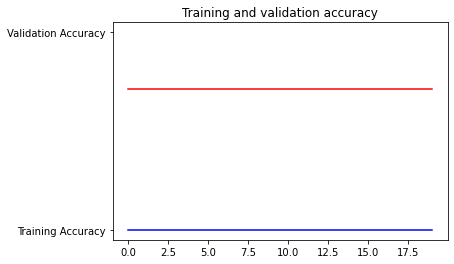

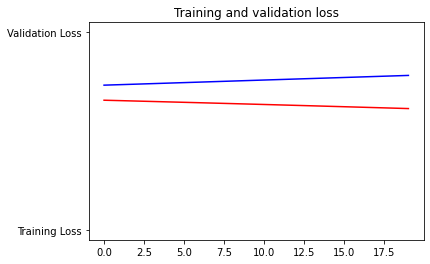

<Figure size 432x288 with 0 Axes>

In [15]:
def se_validate_model(history):
    
    %matplotlib inline
    
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs=range(len(acc))
    
    plt.plot(epochs, acc, 'r', 'Training Accuracy')
    plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'r', 'Training Loss')
    plt.plot(epochs, val_loss, 'b', 'Validation Loss')
    plt.title('Training and validation loss')
    plt.figure()

se_validate_model(history)